* 전체 N개 작업을 N/P개씩 P개 작업 그룹으로 나눈다.
* 각 스레드 또는 코어는 작업 그룹을 하나씩 할당받는다.
* 각 스레드는 할당받은 영역의 값을 계산하고, 그 합을 대표 스레드에게 전달한다.
* 모든 스레드는 각 작업을 마칠 때까지 기다린다.
* 모든 코어가 계산한 합을 대표 스레드가 취합한 후, 그 값을 하나로 더한다.

이 간단한 병렬 처리 알고리즘을 의사 코드(psedu code)로 표현하면 다음과 같은 형태가 된다.
1~2 단계에서 각 코어가 담당할 작업 구역이 my_first와 my_end로 결정되고, 모든 스레드가 ComputeMySum 함수를 통해 자신에게 할당된 작업 그룹을 처리한다.
다음으로 대표 스레드가 아닌 스레드들은 자신의 계산 결과를 대표 스레드에 전달한다.
대표ㅛ 스레드는 모든 스레드의 결과를 취합해서 최종 결과를 계산한다.

컴파일러가 제공하는 자동 병렬화 기능이나 병렬 처리 코드 생성 도구 등을 사용하면 이와 같은 간단한 병렬화를 제공해줄 것이다.
그렇다면 이러한 병렬 처리 알고리즘을 통해 어느 정도 성능이 향상될까?
계산 편의상, 값을 구해서 더하는 연산, 값을 전달받고 더하는 연산 모두 1초가 걸린다고 가정해보자.
만약 데이터 수가 24, 프로세스 수가 8이라면 각 스레드가 3(24 / 8) 개의 값을 구해서 더하고, 대표 스레드는 자신을 제외한 7명에게 데이터를 전달받고 합산해야 한다.

그 결과, 각 스레드의 값 계산 3초와 취합에 소요된 7초를 더해서 총 10초의 시간이 소요된다.
직렬 처리 시 하나의 코어가 24개의 값을 계산하고 더하기 때문에 24초가 걸린다.
즉, 병렬 처리를 통해 2.4 배의 성능 향상을 얻는다.
성능이 향상딘다는 점에서는 긍정적이지만 8개의 코어를 사용했는데 2.4배가 증가한 성능은 조금 아쉽다는 생각이 들 것이다.

더 높은 성능을 얻기 위해 사용하는 코어의 수를 늘리는 경우를 생각해보자.
각 스레드는 N / P 번의 값을 계산 및 합하고 대표 스레드는 (p-1) 번 취합을 수행하므로, N과 P에 따른 연산 소요 시간은 다음과 같이 계산할 수 있다.

* 연산 시간 = N / P + (p - 1)

P가 증가함에 따른 연산 시간의 결과는 어떻게 될까?
일정 수준까지는 성능이 향상되지만, 그 이후부터는 코어 수가 증가하는데도 오히려 성능은 떨어진다.
코어 수가 늘어나는 구간도, 비록 성능이 향상되기는 하지만 그 효율은 점점 낮아지는 것을 확인할 수 있다.

이는 코어의 수가 증가함에 따라 각각의 값을 구하고 작업 그룹 내 합을 구하는 시간은 감소하지만, 그 결과 값을 수집하기 위한 부하(overhead)가 너무 커져서 병렬 처리의 효율을 낮추기 때문에 발생하는 결과다.

그렇다면 더 효율적인 병렬 처리 알고리즘은 없을까?

현재 알고리즘을 보면, 대표 스레드가 전체 결과를 취합하는 부분이 큰 시간을 차지하는 것을 확인할 수 있다.
그리고 그 이유 중 하나는 대표 스레드가 혼자 일하기 때문이다.
그렇다면 최종 취합을 다른 스레드들이 도와줄 수 있는 방법이 없을까?

알고리즘을 다음과 같이 수정해보자.

1. 전체 N개 작업을 N/P 개씩 P개 작업 그룹으로 나눈다.
2. 각 스레드 또는 코어는 작업 그룹을 하나씩 할당받는다.
3. 각 스레드는 할당받은 영역의 값을 계산한다.
4. 모든 스레드가 각 작업을 마칠 때까지 기다린다.
5. (i + 2^(k-1)) 번 코어는 작업을 종료한다.(최초의 k=1)
6. i번 스레드는 (i+2^(k-1)) 번 코어의 결과 값을 가져와서 더한다.
7. k를 1 증가시킨다.
8. 작업에 참여하는 스레드가 더 이상 없을 때까지 5 ~ 7 단계를 반복한다.

N이 24, P가 8일 떄에 총 연산에 소요되는 시간을 계산해보면 취합의 각 단계에서 소요되는 시간이 1초이고 총 3 단께를 통해 전체를 취합할 수 있다.
따라서 각 스레드가 자신에게 할당된 그룹을 처리하는 시간 3초를 더해서 총 6초의 시간이 걸림을 알 수 있다.
이는 직렬 처리 대비 성능이 4배가 된다.
N과 P에 따라 개선된 병렬 처리 알고리즘이 소요하는 시간은 아래와 같이 계산할 수 있다.

개선된 알고리즘의 연산 시간 = N / P + log_2 N

개선된 병렬 알고리즘을 사용하면, 사용하는 코어의 수가 증가함에 따라 지속적으로 성능이 향상되는 것을 볼 수 있다.
즉, 병렬 처리 영역을 최대한 늘림으로써 (값 계산 + 취합 과정), 여러 개의 코어를 사용하는 효율을 극대화하는 것이다.

같은 수의 코어를 사용하더라도 알고리즘을 어떻게 설계하는지에 따라 그 성능이 크게 차이가 날 수 있다.
효율적인 알고리즘 설계를 위해서는 해결할는 문제의 특성 및 연산 자원에 대한 깊은 이해가 필요하다.
이러한 문제 및 자원에 대한 이해를 바탕으로 병렬 처리 알고리즘을 설계하고 개발하는 것은 현재의 자동 병렬화 기술들이 달성하기 힘든 과제다.
즉, 우리가 직접 설계하고 구현해야 하며, 이를 위해 GPU 프로그래밍과 같은 병렬 처리 프로그래밍을 학습해야 한다.

## **1.3. 병렬 처리 하드웨어**
---

병렬 처리 장치에는 GPU 뿐 아니라 멀티코어 CPU 등과 같은 다양한 종류가 있다.
그리고 각각의 병렬 처리 장치는 자신만의 아키텍쳐를 가지며, 각 아키텍쳐의 특성에 따라 병렬 처리 전략 및 적합한 알고리즘이 달라진다.
효율적인 GPU 병렬 처리 알고리즘을 설계 및 구현하기 위해서는 GPU 아키텍쳐의 특징을 이해할 필요가 있다.

#### **1.3.1. 플린의 분류법**

Flynn이 제안한 컴퓨터 아키텍쳐 구분법은 컴퓨팅 하드웨어를 두 가지 기준을 통해 네 종류로 분류한다.
그 기준은 1. 데이터에 대한 한 번에 수행하는 명령여(instruction) 개수와 2. 명령어가(또는 명령어들이) 수행되는 데이터(data) 개수다.

단일명령 - 단일 데이터(Single Instruction Data, SISD)는 하나의 명령어를 하나의 데이터에 대해 수행하는 가장 단순한 구조로, 단일 코어 CPU와 같이 하나의 코어를 가지는 직렬 처리 연산 장치가 이에 속한다.
복수명령 - 단일 데이터(Multiple Instrunction - Single Data, MSID)는 여러 개의 명령어를 하나의 데이ㅣ터에 동시에 수행하는 구조를 말한다.
MSID 구조는 개념적으로만 기술되는, 아직 실현되지 않은 컴퓨터 아키텍쳐다.

실제로는 우리가 컴퓨팅을 위해 사용하는 하드웨어 구조(architecture)는 단일명령-복수 데이터(Single Instruction Data; SIMD), 복수 명령 - 복수 데이터(Multiple Instrunction Multiple Data; MIMD)다.

### **1.3.2. 공유 메모리 시스템과 분산 메모리 시스템**

병렬 처리 하드웨어의 또 다른 분류 기준은 연산 유닛들 사이의 메모리 공유 여부다.
이에 따라 병렬 처리 시스템은 공유 메모리 시스템(Shared memory system)과 분산 메모리 시스템(distributed memory system)으로 구분된다.

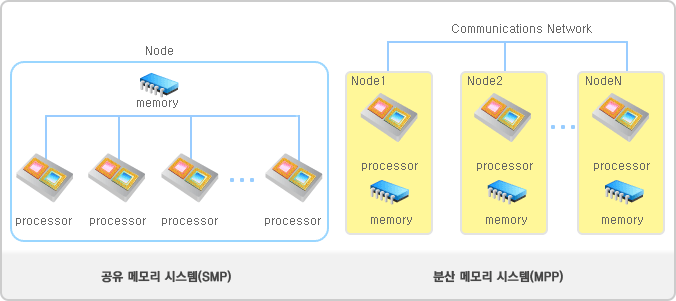

**가. 공유 메모리 시스템**

병렬 시스템 내 연산 유닛들이 하나의 메모리 공간을 공유하는 시스템을 공유 메모리 시스템이라고 한다.
멀티코어 CPU에서 여러 개의 연산 코어가 메인 메모리를 공유하는 것이 대표적인 예시며 GPU도 공유 메모리 시스템에 속한다.
공유 메모리 시스템에서는 여러 스레드가 같은 메모리 공간을 동시에 접근할 수 있기에 메모리 접근 시 주의가 필요하다.
즉, 공유된 메모리 공간에 여러 개의 스레드가 접근할 경우 서로의 작업에 예상치 못한 결과를 야기하지 않도록 서로 작업 순서 등을 맞춰야 하는데, 이러한 과정을 동기화(synchronization)라고 한다.

**나. 분산 메모리 시스템**

병렬 처리 장치 내 각 연산 정치가 독립된 메모리 공간을 갖고, 정보 교환이 필요한 경우 명시적인 통신을 해야 하는 병렬 처리 시스템을 분산 메모리 시스템이라 부른다.
여러 대의 컴퓨팅 노드를 연결해 놓은 컴퓨팅 클러스터가 대표적인 예시며, 일반적인 PC 또한 CPU와 GPU를 동시에 갖기에 분산 메모리 시스템이다.
CPU와 GPU는 모두 공유 메모리 시스템이지만 CPU와 GPU가 사용하는 메모리 공간은 서로 다르며, 두 연산 장치를 함께 사용한다는 측면에서는 이러한 분산 시스템으로 볼 수 있다.
분산 메모리 시스템에서는 네트워크 등을 통해 데이터를 주고 받아야 하며, 통신 부하가 매우 큰 편으로 통신 부하를 줄이기 위한 노력은 효율적인 병렬 처리 알고리즘을 설계하는 데 매우 중요한 요소다.

### **1.4. CPU와 GPU 비교**
---

GPU의 병렬 처리 특성을 이해하려면 GPU의 탄생 배경과 그 발전 경향을 알아볼 필요가 있다.
GPU는 그래픽스 연산을 가속하기 위해 탄생했다.
전통적인 그래픽스 연산의 역할은 2차원 이미지 또는 3차원 공간을 모니터와 같은 평면 디스플레이 장치에 그리는 것이다.
화면에 그린다는 것은 화면을 구성하는 각 픽셀의 색상 값을 결정한다는 의미이며, 이 과정은 그래픽스 파이프라인(graphics pipeline)을 통해 이루어진다.

3차원 공간을 화면에 그리는 작업은 카메라로 사진을 찍는 것과 비슷하다.
간단히 설명하면, 물체에 반사된 빛이 카메라로 들어오고, 카메라 내부에서는 각 픽셀 단위로 들어온 빛의 색이 달라진다.
이 과정을 반대로 생각하면 각 픽셀에서 광선을 쏴서 만나는 물체 일부의 색상 값이 픽셀의 색이 된다.
그리고 각 픽셀의 색상 값은 카메라의 위치 및 각도, 그리고 빛의 세기 및 빛의 방향에 따라 결정된다.
따라서 각 픽셀의 값은 픽셀의 투영되는 표면 정보, 카메라와 빛의 정보를 알면 계산할 수 있다.
이처럼 픽셀의 색상 값을 결정하는 작업은 픽셀 별로 독립적으로 처리할 수 있다.
즉, 병렬 처리가 가능하다.

#### **1.4.1 GPU의 탄생 배경 및 발전 경향**

컴퓨터의 연산 능력이 발전하고 디스플레이 장치의 해상도가 높아짐에 따라 컴퓨터가 다루는 3차원 공간의 복잡도가 크게 증가했다.
따라서 그래픽스 파이프라인 CPU로 처리하는 데 한계가 발생했고, 이를 위한 더 효율적인 처리 장치가 필요함에 따라 탄생한 것이 GPU다.

그래픽스 파이프라인 가속을 위해 탄생한 GPU는 픽셀의 색상 값 계산을 서로 독립적으로 병렬 처리할 수 있도록 개발됐다.
즉, 처음부터 병렬 처리 장치로 탄생했다.
GPU는 주어진 공간 안에 더 많은 연산 코어를 넣는 것에 집중하였으며, 각 픽셀의 색상 값 계산에는 많은 연산이 필요하지 않다는 점에 주목했다.
그 결과 상대적으로 낮은 성능의 코어를 가능한 많이 직접하는 SIMD 형태로 발전을 거듭해왔으며 현재까지 이러한 발전 경향이 이어지고 있다.

그렇게 발전해 오던 GPU는 앞서 언급했듯 일부 연구자들에 의해 다른 목적으로 사용되기 시작했고 병렬 처리 능력이 주목받게 됐다.
이러한 관심은 프로그래밍이 가능한 GPU가 등장하면서 더욱 높아졌으며, 지금의 GPGPU 개념으로 정립됐다.
2000년 대에 들어 GPU들은 GPGPU에 더욱 적합한 형태로 발전했고 기존의 SIMD 구조와는 구분되는 SIMT 구조가 정립됐다.

#### **1.4.2. CPU vs GPU**

지금까지 배운 대부분의 프로그래밍 언어로는 GPU에서 실행되는 코드를 작성했을 것이다.
따라서 CPU 아키텍쳐에 적합한 프로그램 로직 및 작성법에 익숙할 것이다.
GPU를 효율적으로 활용하려면 GPU의 특징을 이해해야 한다.

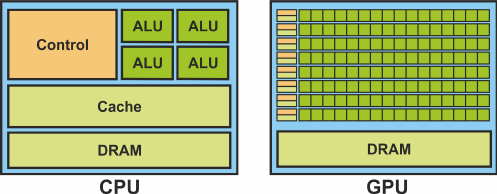

**가. 멀티코어 CPU의 구조**

CPU는 범용 연산 장치다.
즉, 다양한 형태의 연산에 일반적으로 작동하도록 발전해 왔다.
이를 위한 가장 기본적인 접근법은 연산 코어의 성능을 높이는 것이다.
전통적인 기법으로는 코어의 클럭 주파수(clock frequency)를 높이는 것이다.
따라서 단일 코어의 성능은 GPU의 연산 코어보다 뛰어나다.

일반적인 프로그램은 많은 분기를 가지고 있으며, 메모리 접근 또한 불규칙한 경우가 많다.
이러한 불규칙한 동작에 따른 성능 저하를 줄이기 위해 CPU는 분기 예측(branch prediction) 기법과 불규칙한 메모리 접근에 의한 병목현사을 해소할 수 있는 캐시 효율 향상에 많은 투자를 해왔다.
따라서 이러한 기능을 담기 위해 제어 유닛(Control) 및 캐시(DRAM 및 Cache)에 많은 공간을 할애해야 했다.

이처럼 각 연산 코어의 크기가 크고, 제어장치 및 캐시에 많은 공간을 할당하는 멀티코어 CPU는 많은 수의 연산 코어를 넣기 힘들다.
최신 CPU들은 적게는 두 개에서 많게는 수십 개의 코어를 가지며, 이는 수백에서 수천 개의 코어를 가지는 GPU에 비해 매우 적은 개수다.

**나. GPU의 구조**

